In [3]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg

from importlib import reload

import citrus_utils as vitaminC

In [2]:
reload(vitaminC)

<module 'citrus_utils' from '/home/ejam/documents/citrus/citrus/citrus_utils.py'>

Adapted from 
> Li, Qingde & Griffiths, J. G. (2004). Least squares ellipsoid specific fitting. _Geometric Modeling and Processing, 2004. Proceedings_, 335–340. DOI: [10.1109/GMAP.2004.1290055](https://doi.org/10.1109/GMAP.2004.1290055)

## Measure of sphericity

Assume the ellipsoid axes are aligned with the reference $XYZ$ axes and that it is centered at the origin. Then its general equation can be written as

$$ax^2 + by^2 + cz^2 = 1.$$

We can thus compute the unitless measurement:

$$\rho = \frac{4J-I}{a^2 + b^2 + c^2},$$

with

$$I = a+b+c,\quad J=ab+ bc+ ca$$

Using the Cauchy-Schwarz inequality, we can show that $|\rho| \leq 1$ and $\rho=1$ iff $a=b=c$. It can also be observed that $\rho\to-1$ whenever the ellipsoid is extremely flat or extremely elongated.

In [4]:
def ell_rho(axes):
    a,b,c = 1./(np.asarray(axes)**2)
    I = a + b + c
    J = a*b + b*c + c*a
    #K = np.linalg.det(np.array([[a, h, g], [h, b, f], [g, f, c] ]))
    rho = (4*J - I*I)/(a**2 + b**2 + c**2)
    return rho

def ell_algebraic_fit2(datapoints, k=4):

    x,y,z = datapoints
    C1 = np.diag([-1, -1, -1, -k, -k, -k])
    C1[0,1:3] = .5*k - 1
    C1[1:3, 0] = .5*k - 1
    C1[1,2] = .5*k - 1
    C1[2,1] = .5*k - 1
    D = np.vstack((x**2, y**2, z**2, 2*x*y, 2*x*z, 2*y*z, 2*x, 2*y, 2*z, np.ones_like(x)))

    DDT = D@D.T
    S11 = DDT[:6, :6]
    S12 = DDT[:6, 6:]
    S22 = DDT[6:, 6:]

    M = (linalg.inv(C1))@(S11 - S12@linalg.inv(S22)@(S12.T))
    eigvals, eigvecs = np.linalg.eig(M)
    v1 = eigvecs[:, np.argmax(eigvals)]
    v2 = -linalg.inv(S22)@(S12.T)@v1

    v = -np.hstack((v1,v2))/v2[-1]

    a,b,c,f,g,h, p,q,r, d = v
    I = a + b + c
    J = a*b + b*c + c*a - f*f/4 - g*g/4 - h*h/4
    aux = k*J - I*I
    
    return v, aux > 0

In [5]:
ax, ay, az = 2, 10, 6
domain_lon = [-np.pi, np.pi]
domain_lat = [-.5*np.pi, 0.5*np.pi]
lonN = 250
latN = 150

longitude = np.linspace(*domain_lon, lonN)
latitude = np.linspace(*domain_lat, latN)

shape_lon, shape_lat = np.meshgrid(longitude, latitude)
lonlat = np.vstack((np.ravel(shape_lon), np.ravel(shape_lat)))

shape_x = vitaminC.ellipsoid(shape_lon, shape_lat, ax, ay, az)

choice = np.random.randint(10*lonN, lonlat.shape[1]-10*lonN, int(2e2))
coords = vitaminC.ellipsoid(*(lonlat[:,choice]), ax, ay, az)

rng = np.random.default_rng(42)
bar = coords.copy()
noise = rng.normal(0, .1*np.min((ax,ay,az)),  bar.shape)
foo = bar# + noise 

-0.6931678712668758


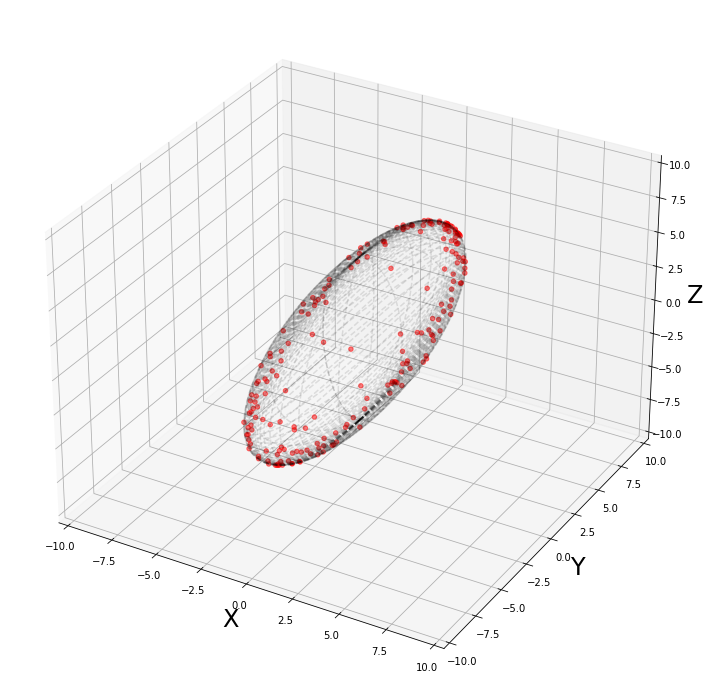

In [6]:
fs = 24

# Set up plot
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0, wspace=0.1, bottom=.2)
axes = fig.add_subplot(111, projection='3d')
lim = np.max([ax, ay, az]) + .1
axes.set_xlim(-lim, lim);axes.set_ylim(-lim, lim);axes.set_zlim(-lim, lim)
axes.set_xlabel('X', fontsize=fs)
axes.set_ylabel('Y', fontsize=fs)
axes.set_zlabel('Z', fontsize=fs)
#axes.plot_surface(*shape_x)
axes.plot_wireframe(*shape_x, color='black', ls="--", alpha = 0.1);
axes.scatter(*foo, color='red', alpha=0.5);
#axes.scatter(*bar, color='black', alpha=0.8, s=50, marker='*');
#axes.scatter(*footpoint, color='blue', alpha=0.8, marker='v', s=50);
#axes.scatter(*fpts, color='cyan', alpha=0.8, marker='^', s=50);
print(ell_rho([ax,ay,az]))

In [9]:
datapoints.shape

(3, 200)

In [7]:
datapoints = foo.copy()
nameN = ['minN', 'meanN', 'maxN', 'rmsN']
v, flag = ell_algebraic_fit2(datapoints, k=256)
print(np.around(v,3), '\n', flag, 'ellipsoid\n')
ell_params = vitaminC.get_ell_params_from_vector(v)
geoid, xyz = vitaminC.get_footpoints(datapoints, ell_params)
valN = vitaminC.geoid_heights(datapoints, xyz)
for i in range(len(nameN)):
    print(nameN[i], ':\t{:.4f}'.format(valN[i]))
print(ell_rho(ell_params['axes']))
ell_params

[ 0.25   0.01   0.028  0.     0.     0.     0.     0.    -0.    -1.   ] 
 True ellipsoid

minN :	0.0000
meanN :	0.0000
maxN :	0.0000
rmsN :	0.0000
-0.6931678712668845


{'center': array([-1.82587905e-15, -8.91800088e-16,  1.82981138e-16]),
 'axes': array([ 2.,  6., 10.]),
 'rotation': array([[ 1.00000000e+00,  1.55376960e-16,  1.25006385e-16],
        [-1.25006385e-16,  2.22044605e-16,  1.00000000e+00],
        [-1.55376960e-16,  1.00000000e+00, -2.72829671e-16]]),
 'theta': array([ 1.57079633e+00, -1.55376960e-16,  1.25006385e-16])}

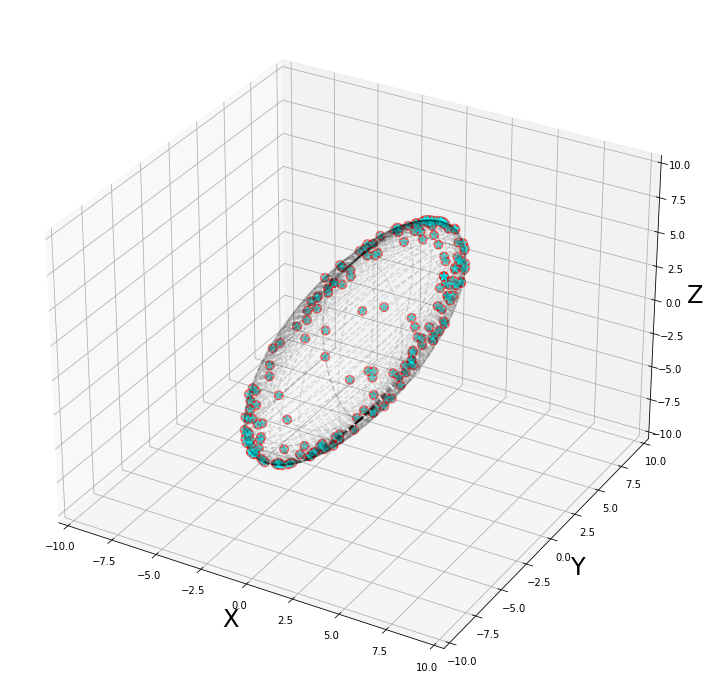

In [6]:
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0, wspace=0.1, bottom=.2)
axes = fig.add_subplot(111, projection='3d')
axes.set_xlim(-lim, lim);axes.set_ylim(-lim, lim);axes.set_zlim(-lim, lim)
axes.set_xlabel('X', fontsize=fs);axes.set_ylabel('Y', fontsize=fs);axes.set_zlabel('Z', fontsize=fs)
axes.plot_wireframe(*shape_x, color='black', ls="--", alpha = 0.1);
axes.scatter(*foo, color='red', alpha=0.5, s=80);
axes.scatter(*xyz, color='cyan', alpha=0.5, s=80, marker='*');

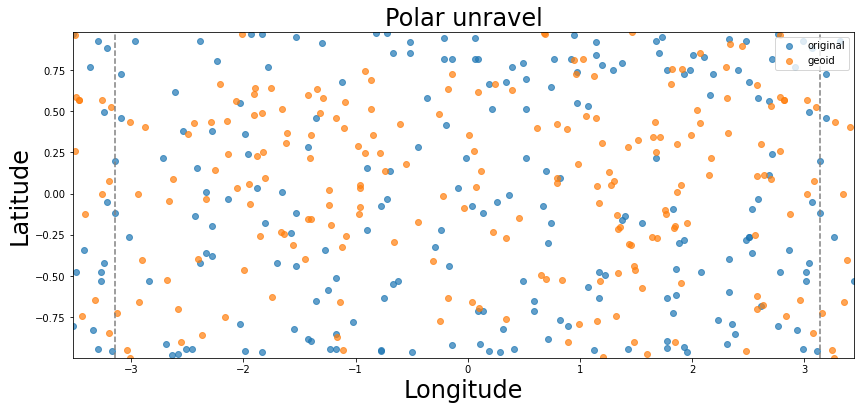

In [7]:
geoid_map, _ = vitaminC.cyl_overlap(*geoid[:2])
original_map, _ = vitaminC.cyl_overlap(*lonlat[:, choice])
plt.figure(figsize=(14,6))
plt.scatter(original_map[:,0], np.sin(original_map[:,1]), alpha=0.7, label='original')
plt.scatter(geoid_map[:,0], np.sin(geoid_map[:,1]), alpha=0.7, label='geoid')
plt.xlabel('Longitude', fontsize=fs)
plt.ylabel('Latitude', fontsize=fs);
plt.title('Polar unravel', fontsize=fs);
plt.axvline(x=-np.pi, c='gray', ls='--'); plt.axvline(x=np.pi, c='gray', ls='--');
plt.margins(x=0, y=0);
plt.legend();

In [12]:
ecoords = vitaminC.ellipsoid(*geoid[:2], *(ell_params['axes']))
#ecoords = vitaminC.ellipsoid(*geoid[:2], ax, ay, az)

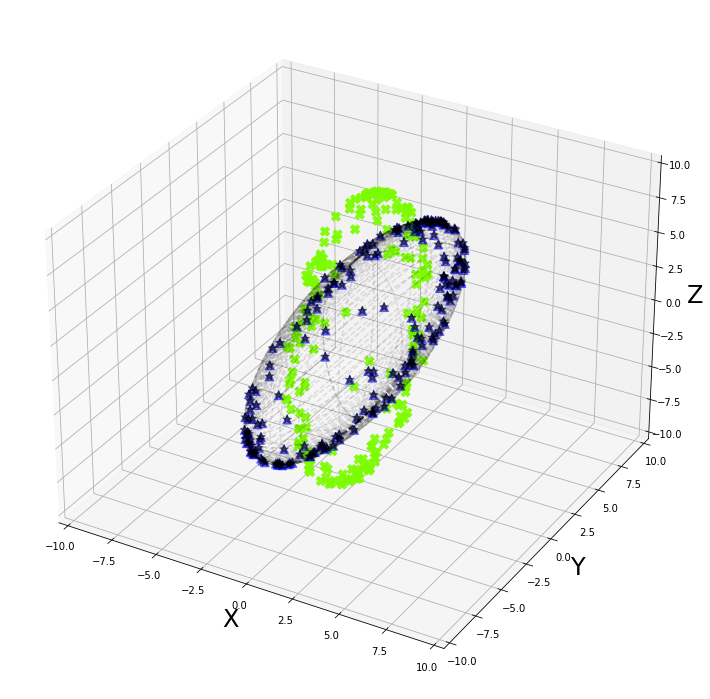

In [13]:
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0, wspace=0.1, bottom=.2)
axes = fig.add_subplot(111, projection='3d')
axes.set_xlim(-lim, lim);axes.set_ylim(-lim, lim);axes.set_zlim(-lim, lim)
axes.set_xlabel('X', fontsize=fs);axes.set_ylabel('Y', fontsize=fs);axes.set_zlabel('Z', fontsize=fs)
axes.plot_wireframe(*shape_x, color='black', ls="--", alpha = 0.1);
#axes.scatter(*foo, color='magenta', alpha=0.5, s=80);
axes.scatter(*xyz, color='blue', alpha=0.5, s=80, marker='^');
axes.scatter(*bar, color='black', alpha=0.5, s=80, marker='*');
axes.scatter(*ecoords, color='lawngreen', alpha=0.9, s=80, marker='X');

In [237]:
def get_geoids(datapoints, ell_params):
    t = ell_params['center']
    R = ell_params['rotation']
    axes = ell_params['axes']

    UVW = R @ (datapoints - t.reshape(-1,1))
    signs = UVW < 0
    
    argmax = np.argmax(np.abs(ell_params['rotation']), axis=1)
    
    geodetic, footpoints = vitaminC.CartesianIntoGeodeticI(*(axes[argmax]), *UVW)
    uvw = np.where(signs, -1, 1)*footpoints
    xyz = t.reshape(-1,1) + R.T @ uvw
    return vitaminC.correct_signs(geodetic, signs), xyz

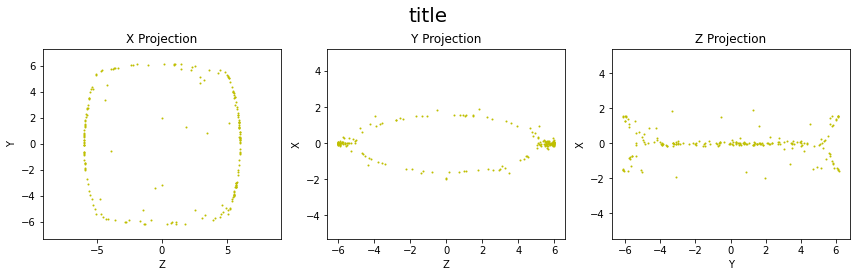

In [26]:
vitaminC.plot_3Dprojections(footpoints.T)

In [34]:
t = ell_params['center']
R = ell_params['rotation']
axs = ell_params['axes']

UVW = (xyz - t.reshape(-1,1))
signs = UVW < 0

argmax = np.argmax(np.abs(ell_params['rotation']), axis=1)
geodetic, footpoints = vitaminC.CartesianIntoGeodeticI(*(axs[argmax]), *UVW)
footpoints = np.where(signs, -1, 1)*footpoints
geodetic = vitaminC.correct_signs(geodetic, signs)

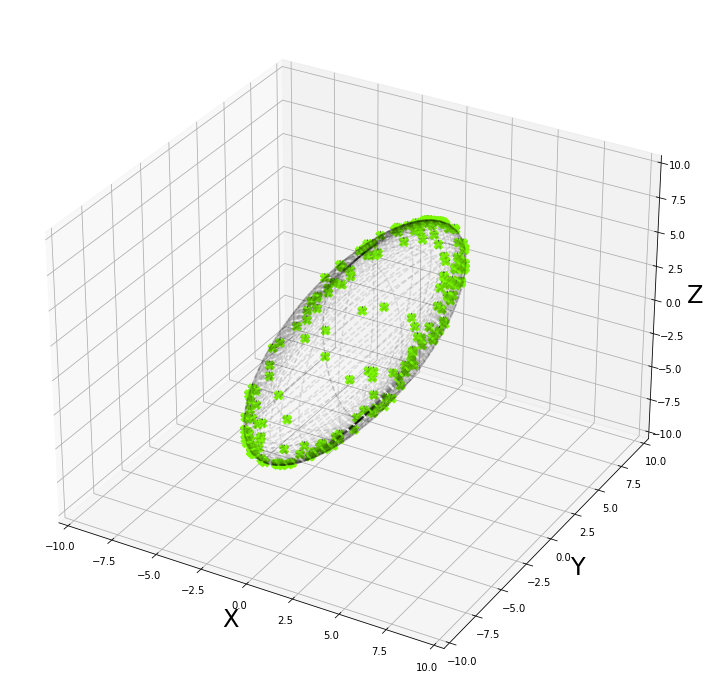

In [35]:
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0, wspace=0.1, bottom=.2)
axes = fig.add_subplot(111, projection='3d')
axes.set_xlim(-lim, lim);axes.set_ylim(-lim, lim);axes.set_zlim(-lim, lim)
axes.set_xlabel('X', fontsize=fs);axes.set_ylabel('Y', fontsize=fs);axes.set_zlabel('Z', fontsize=fs)
axes.plot_wireframe(*shape_x, color='black', ls="--", alpha = 0.1);
#axes.scatter(*foo, color='magenta', alpha=0.5, s=80);
#axes.scatter(*xyz, color='blue', alpha=0.5, s=80, marker='^');
axes.scatter(*UVW, color='black', alpha=0.5, s=80, marker='*');
axes.scatter(*footpoints, color='lawngreen', alpha=0.9, s=80, marker='X');

In [43]:
np.argmax(np.abs(ell_params['rotation']), axis=1)

array([0, 2, 1])

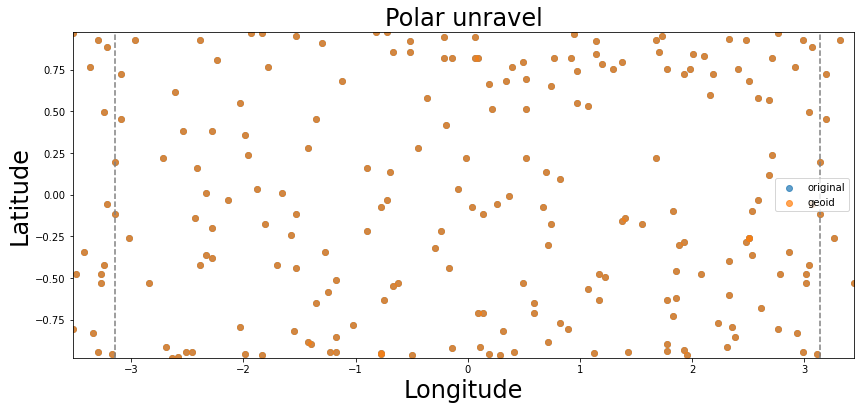

In [36]:
geoid_map, _ = vitaminC.cyl_overlap(*geodetic[:2])
original_map, _ = vitaminC.cyl_overlap(*lonlat[:, choice])
plt.figure(figsize=(14,6))
plt.scatter(original_map[:,0], np.sin(original_map[:,1]), alpha=0.7, label='original')
plt.scatter(geoid_map[:,0], np.sin(geoid_map[:,1]), alpha=0.7, label='geoid')
plt.xlabel('Longitude', fontsize=fs)
plt.ylabel('Latitude', fontsize=fs);
plt.title('Polar unravel', fontsize=fs);
plt.axvline(x=-np.pi, c='gray', ls='--'); plt.axvline(x=np.pi, c='gray', ls='--');
plt.margins(x=0, y=0);
plt.legend();

In [38]:
np.around(R @ (R.T), 4) 

array([[ 1., -0., -0.],
       [-0.,  1., -0.],
       [-0., -0.,  1.]])

In [41]:
RR = R[:, argmax]
np.around(RR @ (RR.T), 4) 

array([[ 1., -0., -0.],
       [-0.,  1., -0.],
       [-0., -0.,  1.]])